In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.dpi' : 100,
    'figure.facecolor': 'white',
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'font.size' : 12
})

import numpy as np
import hcipy as hp
from poppy import zernike
from importlib import reload
import os
os.chdir('C:/Users/KAJA/Documents/Kevin/03 STP/stp_context_pr_sims/code')
import wcc
import fdpr2
import utils

reload(wcc)

from scipy.stats import binned_statistic_2d
from scipy.special import hyp2f1

Model parameters:

In [15]:
# throughput calculation
refl_BAL = 0.9 # bare aluminum primary
refl_ALSiO2 = 0.9 # Al + SiO2 for M2-M4
BS = 1.0 # for getting two defocused fields
material_throughput = refl_BAL * (refl_ALSiO2**3) * BS

model_params = {'D_aperture' : 6.46, # primary (m)
                'D_secondary' : 1.3, # secondary (m) (estimate)
                'spider_width' : 0.15, # (m) (complete guess)
                'wavelength' : 650e-9, # (m) V-band
                'wavelength_sampling' : 3,
                'fnum' : 15., # f number at context cam
                'D_pix' : 3.76e-6, # pixel size for context cam
                'read_noise' : 3.7, # read noise (3.7 e- at low gain; 1 e- at high gain)
                'QE' : 0.8, # value at 600 nm, UPDATE FOR 550 nm
                'dark_current' : 0.0022, #e-/pix/s at -20 C (0.014 at 0C)
                'pix_pupil' : 256, 
                'D_detector' : 100, # lambda/D
                'vals_defocus' : [-0.25, 0.75], # waves
                'throughput' : material_throughput,
                'bandwidth' : 10./650.,
                'lambda_rms' : 50./650., # waves RMS for desired Strehl of 0.4
                't_exposure' : 30, # seconds
                't_frame': 5 # seconds
                }

Forward Model:

([], [])

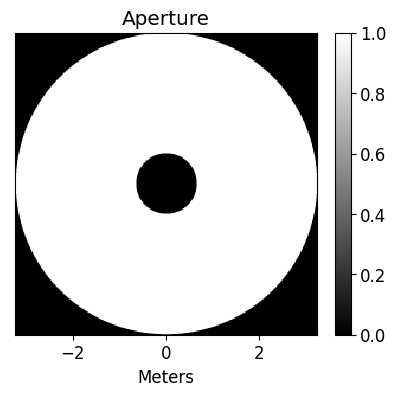

In [16]:
# model
ap_spider, ap_nospider, prop_f, prop_df, det = wcc.get_model(model_params)

hp.imshow_field(ap_nospider, cmap='gray');
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Aperture'); plt.xlabel('Meters'); plt.yticks([])

Surface shape from Quartus thermal analysis:

In [88]:
from scipy.io import loadmat

os.chdir('C:/Users/KAJA/Documents/Kevin/03 STP/20230310_close_loop_example')
data = loadmat("HK1_Case8_1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'WFE_data', 'zern_data'])

736.9750542256986


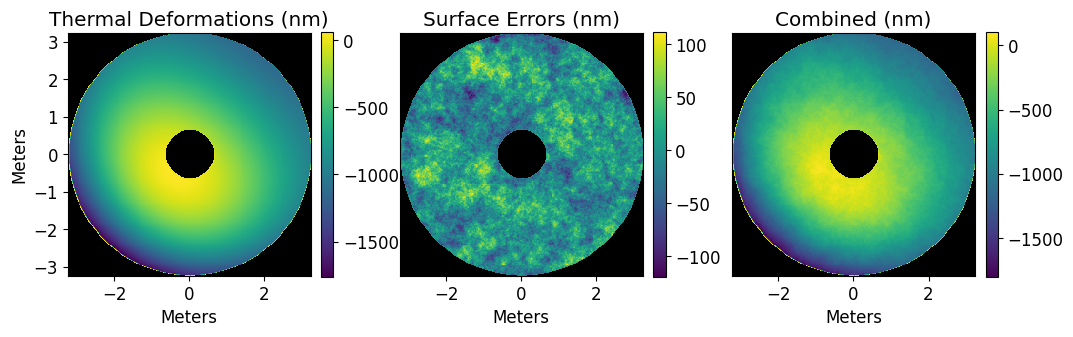

In [94]:
from skimage.transform import downscale_local_mean

# thermal surface deformations
wfe_therm = data['WFE_data'] * 650e-9 # waves to meters
surf_therm = wfe_therm / 2 # wavefront to surface error
surf_therm[np.isnan(surf_therm)] = 0 # get rid of nans
surf_therm = downscale_local_mean(surf_therm, (2, 2)) # downsample to fit pupil grid

# thermal errors are mostly thru z10 so remove them
remove = hp.mode_basis.make_zernike_basis(10, model_params['D_aperture'], ap_nospider.grid)

# high order surface errors 
rms = 15e-9
ho = hp.optics.make_power_law_error(ap_nospider.grid, 1, model_params['D_aperture'], -2.5, ap_nospider, remove)
ho *= rms / utils.rms(ho, ap_nospider.astype(bool)) # normalize to rms of M1 - M4 surface errors

# add together for final surface
surf = hp.SurfaceApodizer(hp.Field(surf_therm.ravel() + ho.ravel(), ap_nospider.grid), -1)
surf_therm = hp.SurfaceApodizer(hp.Field(surf_therm.ravel(), ap_nospider.grid), -1)
surf_ho = hp.SurfaceApodizer(hp.Field(ho.ravel(), ap_nospider.grid), -1)

# aberrated wavefront
wfs = wcc.get_wavefronts(model_params, ap_nospider, target_magnitude=10, monochromatic=True)
wfs[0] = surf(wfs[0])

plt.figure(figsize=(12,4))
plt.subplot(131)
hp.imshow_field(surf_therm.opd * 1e9, mask=ap_nospider.astype(bool))
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Thermal Deformations (nm)'); plt.xlabel('Meters'); plt.ylabel('Meters')
plt.subplot(132)
hp.imshow_field(surf_ho.opd * 1e9, mask=ap_nospider.astype(bool))
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Surface Errors (nm)'); plt.xlabel('Meters'); plt.yticks([])
plt.subplot(133)
hp.imshow_field(surf.opd * 1e9, mask=ap_nospider.astype(bool))
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Combined (nm)'); plt.xlabel('Meters'); plt.yticks([])
plt.subplots_adjust(wspace=0.25);

print(utils.rms(surf_therm.opd * 1e9, mask=ap_nospider.astype(bool)))

Get some PSFs:

C:\Users\KAJA\AppData\Local\Temp\ipykernel_17352\172369587.py:13: RuntimeWarning: divide by zero encountered in log10
  hp.imshow_field(np.log10(focus_im / focus_im.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
C:\Users\KAJA\AppData\Local\Temp\ipykernel_17352\172369587.py:17: RuntimeWarning: divide by zero encountered in log10
  hp.imshow_field(np.log10(defocus_im1 / defocus_im1.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
C:\Users\KAJA\AppData\Local\Temp\ipykernel_17352\172369587.py:21: RuntimeWarning: divide by zero encountered in log10
  hp.imshow_field(np.log10(defocus_im2 / defocus_im1.max()), grid_units=spatial_res, cmap='magma', vmin=-5)


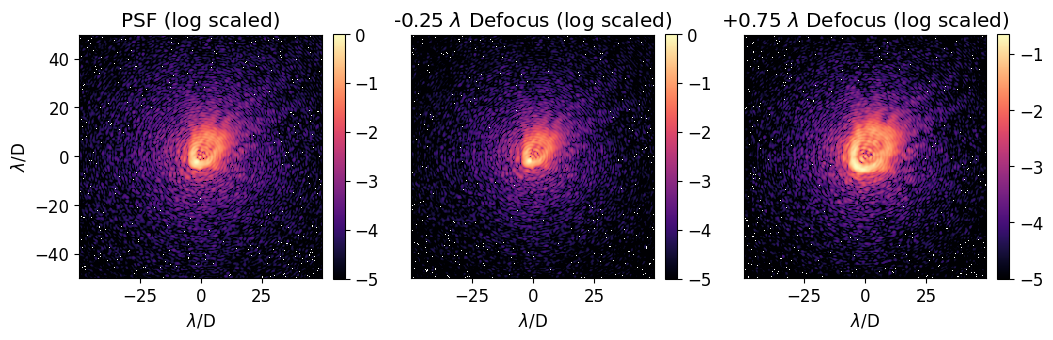

In [18]:
focus_wfs = wcc.prop_wavefronts(model_params, wfs, prop_f)
defocus_wfs1 = wcc.prop_wavefronts(model_params, focus_wfs, prop_df[0])
defocus_wfs2 = wcc.prop_wavefronts(model_params, focus_wfs, prop_df[1])

focus_im = wcc.get_image(model_params, focus_wfs, det)
defocus_im1 = wcc.get_image(model_params, defocus_wfs1, det)
defocus_im2 = wcc.get_image(model_params, defocus_wfs2, det)

spatial_res = model_params['fnum'] * model_params['wavelength']

plt.figure(figsize=(12, 4))
plt.subplot(131)
hp.imshow_field(np.log10(focus_im / focus_im.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('PSF (log scaled)'); plt.xlabel('$\lambda$/D'); plt.ylabel('$\lambda$/D');
plt.subplot(132)
hp.imshow_field(np.log10(defocus_im1 / defocus_im1.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('-0.25 $\lambda$ Defocus (log scaled)'); plt.xlabel('$\lambda$/D'); plt.yticks([]);
plt.subplot(133)
hp.imshow_field(np.log10(defocus_im2 / defocus_im1.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('+0.75 $\lambda$ Defocus (log scaled)'); plt.xlabel('$\lambda$/D'); plt.yticks([]);
plt.subplots_adjust(wspace=0.25);

Phase retrieval:

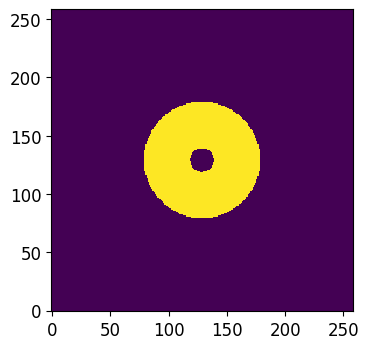

In [19]:
from skimage.filters import threshold_otsu

pupil_fft = np.abs(utils.ifft2_shiftnorm(focus_wfs[0].electric_field.shaped))
thresh = threshold_otsu(pupil_fft)
fitmask = pupil_fft > thresh

plt.imshow(fitmask)

In [59]:
# PV to RMS and sign convention change
Ediv = fdpr2.get_defocus_probes(fitmask, -0.25 * np.asarray(model_params['vals_defocus']))

tol = 1e-6
reg = 0
wreg = 10
modes = zernike.arbitrary_basis(fitmask, nterms=100, outside=0)

# square-ify the PSFs
psfs_sq = np.asarray([defocus_im1.shaped, defocus_im2.shaped])

In [60]:
# run pr
#prdict = fdpr2.run_phase_retrieval(psfs_sq, fitmask, tol, reg, wreg, Ediv, modes=None, fit_amp=True)
prdict = fdpr2.run_phase_retrieval(psfs_sq, fitmask, tol, reg, wreg, Ediv, modes=modes, fit_amp=False)

phase_true = surf.opd * 2 * np.pi / model_params['wavelength'] # calculate here to avoid wrapping

Text(0.5, 1.0, 'Estimated Phase')

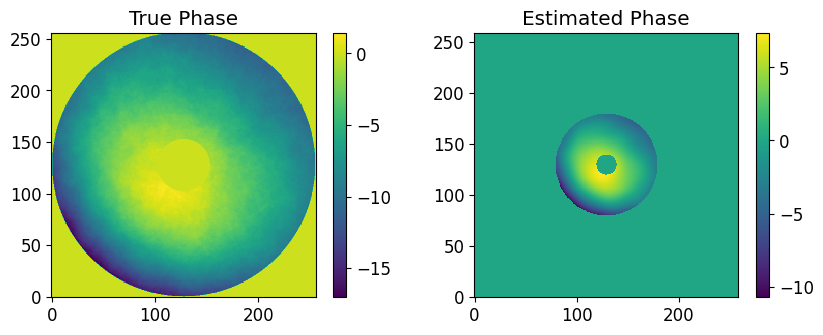

In [61]:
plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(phase_true.shaped); plt.colorbar()
plt.title('True Phase')
plt.subplot(122)
plt.imshow(prdict['phase_est']); plt.colorbar()
plt.title('Estimated Phase')

In [102]:
from copy import deepcopy
from skimage.transform import resize

prcopy = deepcopy(prdict)

est = prcopy['phase_est'][80:179, 80:179]
tru = resize(phase_true.shaped, np.shape(est))

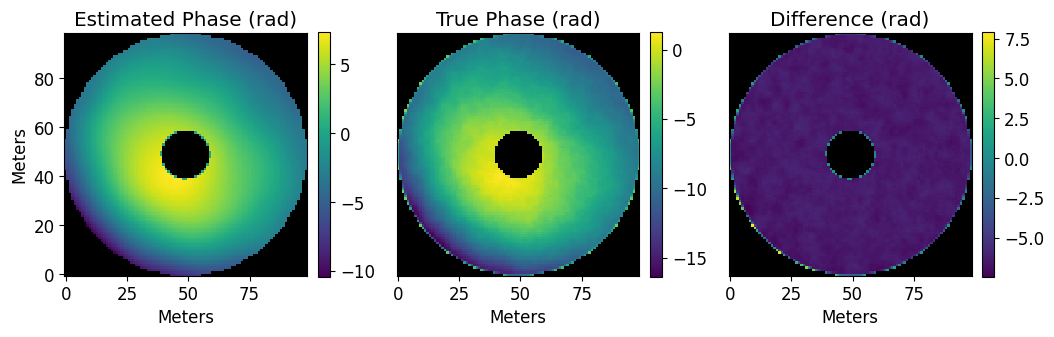

In [103]:
import matplotlib.cm as colors

aperture_mask = resize(ap_nospider.shaped.astype(bool), np.shape(est))
est[~aperture_mask] = np.nan
tru[~aperture_mask] = np.nan

cmap = colors.viridis
cmap.set_bad('black',1.)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(est, cmap=cmap)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Estimated Phase (rad)'); plt.xlabel('Meters'); plt.ylabel('Meters')
plt.subplot(132)
plt.imshow(tru, cmap=cmap)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('True Phase (rad)'); plt.xlabel('Meters'); plt.yticks([])
plt.subplot(133)
plt.imshow(tru - est, cmap=cmap)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Difference (rad)'); plt.xlabel('Meters'); plt.yticks([])
plt.subplots_adjust(wspace=0.25);

In [40]:
from scipy.io import savemat

matdict = {'phase_estimate' : est,
           'wavelength' : 650e-9,
           'wfe_estimate' : est / 2 / np.pi * 650e-9}

os.chdir('C:/Users/KAJA/Documents/Kevin/03 STP/20230310_close_loop_example')
savemat("HK1_Case8_1_pr.mat", matdict)

Text(0, 0.5, 'Meters')

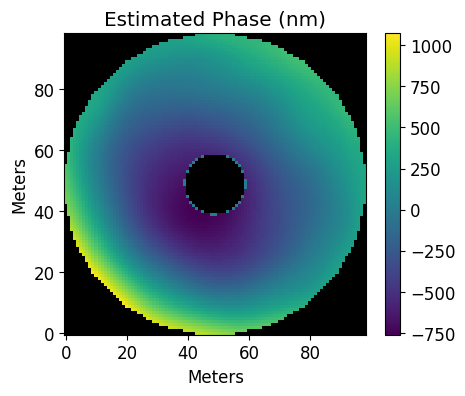

In [65]:
plt.imshow(est / 2 / np.pi * 650e-9 * 1e9, cmap=cmap)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Estimated Phase (nm)'); plt.xlabel('Meters'); plt.ylabel('Meters')

In [96]:
os.chdir('C:/Users/KAJA/Documents/Kevin/03 STP/20230310_close_loop_example')
data = loadmat("case 8 HK data 1.00_68modes_corrected_wfe.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'zernike_coeff', 'wfe_data'])

32.500987153903935


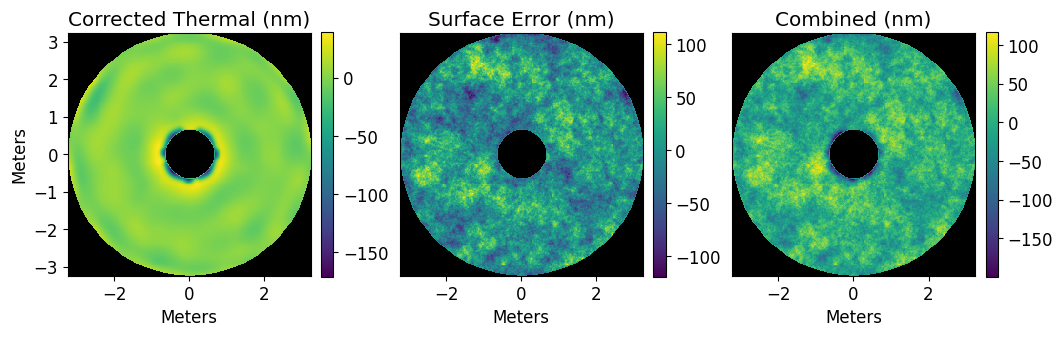

In [99]:
# thermal surface deformations
wfe_corrected = data['wfe_data'] * 1e-9 # nm to meter
surf_corrected = wfe_corrected / 2 # wavefront to surface error
surf_corrected[np.isnan(surf_corrected)] = 0 # get rid of nans
surf_corrected = resize(surf_corrected, (256, 256)) # resize to fit pupil grid

# thermal errors are mostly thru z10 so remove them
remove = hp.mode_basis.make_zernike_basis(10, model_params['D_aperture'], ap_nospider.grid)

# add with previous high order error for final surface
surf = hp.SurfaceApodizer(hp.Field(surf_corrected.ravel() + ho.ravel(), ap_nospider.grid), -1)
surf_corrected = hp.SurfaceApodizer(hp.Field(surf_corrected.ravel(), ap_nospider.grid), -1)

# aberrated wavefront
wfs = wcc.get_wavefronts(model_params, ap_nospider, target_magnitude=10, monochromatic=True)
wfs[0] = surf(wfs[0])

plt.figure(figsize=(12,4))
plt.subplot(131)
hp.imshow_field(surf_corrected.opd * 1e9, mask=ap_nospider.astype(bool))
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Corrected Thermal (nm)'); plt.xlabel('Meters'); plt.ylabel('Meters')
plt.subplot(132)
hp.imshow_field(surf_ho.opd * 1e9, mask=ap_nospider.astype(bool))
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Surface Error (nm)'); plt.xlabel('Meters'); plt.yticks([])
plt.subplot(133)
hp.imshow_field(surf.opd * 1e9, mask=ap_nospider.astype(bool))
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Combined (nm)'); plt.xlabel('Meters'); plt.yticks([])
plt.subplots_adjust(wspace=0.25);

print(utils.rms(surf.opd * 1e9, mask=ap_nospider.astype(bool)))

C:\Users\KAJA\AppData\Local\Temp\ipykernel_17352\3140223071.py:8: RuntimeWarning: divide by zero encountered in log10
  hp.imshow_field(np.log10(focus_im / focus_im.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
C:\Users\KAJA\AppData\Local\Temp\ipykernel_17352\3140223071.py:12: RuntimeWarning: divide by zero encountered in log10
  hp.imshow_field(np.log10(focus_im2 / focus_im2.max()), grid_units=spatial_res, cmap='magma', vmin=-5)


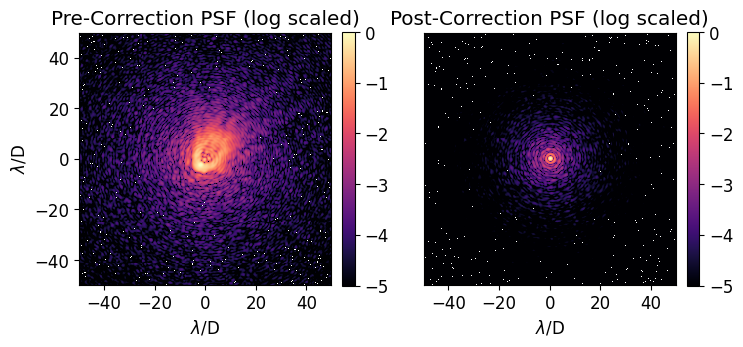

In [80]:
focus_wfs2 = wcc.prop_wavefronts(model_params, wfs, prop_f)
focus_im2 = wcc.get_image(model_params, focus_wfs2, det)

spatial_res = model_params['fnum'] * model_params['wavelength']

plt.figure(figsize=(8, 4))
plt.subplot(121)
hp.imshow_field(np.log10(focus_im / focus_im.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Pre-Correction PSF (log scaled)'); plt.xlabel('$\lambda$/D'); plt.ylabel('$\lambda$/D');
plt.subplot(122)
hp.imshow_field(np.log10(focus_im2 / focus_im2.max()), grid_units=spatial_res, cmap='magma', vmin=-5)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Post-Correction PSF (log scaled)'); plt.xlabel('$\lambda$/D'); plt.yticks([]);
plt.subplots_adjust(wspace=0.25);